# Entendiendo el Forward Pass, Loss, Backward Pass y Optimización

## Introducción

En esta notebook aprenderemos los conceptos fundamentales que están en el corazón de cualquier red neuronal:

- **Forward Pass**: Cómo fluyen los datos a través de la red
- **Función de Pérdida (Loss)**: Cómo medimos qué tan bien (o mal) lo está haciendo nuestro modelo
- **Backward Pass**: Cómo calculamos los gradientes para mejorar el modelo
- **Optimización**: Cómo actualizamos los parámetros para aprender

Utilizaremos el problema clásico **XOR** como ejemplo práctico. Este problema es perfecto para entender estos conceptos porque:
1. Es simple de visualizar (solo 4 casos)
2. Requiere una red neuronal (no es linealmente separable)
3. Nos permite ver claramente cómo aprende la red

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchviz import make_dot

Vamos a resolver XOR paso a paso usando PyTorch.

Tabla de verdad XOR:

| Entrada 1 | Entrada 2 | Salida (XOR) |
|-----------|-----------|--------------|
|     0     |     0     |      0       |
|     0     |     1     |      1       |
|     1     |     0     |      1       |
|     1     |     1     |      0       |

Este problema es famoso en el mundo de las redes neuronales porque fue uno de los primeros en demostrar las limitaciones del perceptrón simple y la necesidad de redes multicapa.


In [2]:
# Datos para XOR
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

El problema es que la función XOR no es linealmente separable, lo que significa que no podemos trazar una línea recta que separe las clases de salida. O sea, no existe un modelo lineal que pueda resolver este problema. Para abordar esto, utilizaremos una red neuronal con al menos una capa oculta.

In [3]:
class SimpleXOR(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 4)  # Capa oculta: 2 entradas -> 4 neuronas
        self.output = nn.Linear(4, 1)  # Capa salida: 4 neuronas -> 1 salida
        
    def forward(self, x):
        # Guardamos los valores intermedios para poder examinarlos
        h = self.hidden(x)  # Transformación lineal: x @ W + b
        h_activated = torch.sigmoid(h)  # Activación sigmoid
        out = self.output(h_activated)  # Segunda transformación lineal
        out_activated = torch.sigmoid(out)  # Activación final
        
        return  out_activated

In [4]:
# Instanciamos la red
net = SimpleXOR()

print("Arquitectura de nuestra red:")
print("Input(2) -> Linear(2,4) -> Sigmoid -> Linear(4,1) -> Sigmoid -> Output(1)")

print("\nParámetros iniciales:")
print("Pesos capa oculta (W1):")
print(net.hidden.weight.data)
print("Bias capa oculta (b1):")
print(net.hidden.bias.data)
print("Pesos capa salida (W2):")
print(net.output.weight.data)
print("Bias capa salida (b2):")
print(net.output.bias.data)

Arquitectura de nuestra red:
Input(2) -> Linear(2,4) -> Sigmoid -> Linear(4,1) -> Sigmoid -> Output(1)

Parámetros iniciales:
Pesos capa oculta (W1):
tensor([[ 0.7047, -0.0899],
        [ 0.4470,  0.0388],
        [-0.1904, -0.5857],
        [ 0.4651,  0.3358]])
Bias capa oculta (b1):
tensor([ 0.3353,  0.5830, -0.5413, -0.2671])
Pesos capa salida (W2):
tensor([[-0.2826,  0.0004, -0.3152, -0.2397]])
Bias capa salida (b2):
tensor([-0.4795])


## Forward Pass 

El Forward Pass es el proceso mediante el cual la información se mueve a través de la red neuronal, desde la entrada hasta la salida. Cada operación (multiplicación de matrices, suma, aplicación de funciones de activación) crea nodos en el **grafo computacional**.

Este grafo es fundamental porque:
- Registra todas las operaciones realizadas
- Permite calcular gradientes automáticamente durante el backward pass
- Nos ayuda a entender el flujo de datos

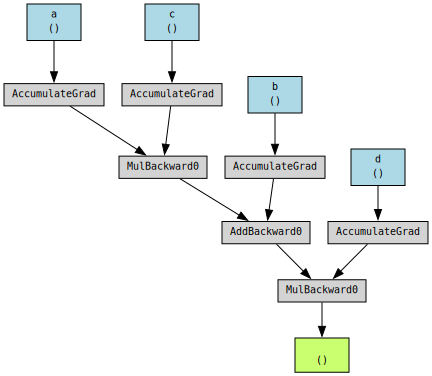

In [5]:
a = torch.tensor(5, dtype=torch.float32, requires_grad=True)
b = torch.tensor(3, dtype=torch.float32, requires_grad=True)
c = torch.tensor(2, dtype=torch.float32, requires_grad=True)
d = torch.tensor(1, dtype=torch.float32, requires_grad=True)

x = (a * c + b) * d

# grafo computacional
# Crear visualización
dot = make_dot(x, params={"a": a, "b": b, "c": c, "d": d})
dot

Veamos que pasa cuando hacemos un forward pass con nuestro modelo.

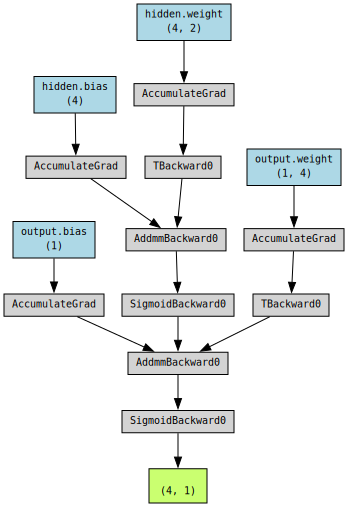

In [19]:
y_hat = net(X)

dot = make_dot(y_hat, params=dict(list(net.named_parameters())))
dot

- AddmmBackward0 = Capas lineales (nn.Linear) -> [torch.addmm](https://docs.pytorch.org/docs/stable/generated/torch.addmm.html)
- SigmoidBackward0 = Funciones de activación [torch.sigmoid](https://docs.pytorch.org/docs/stable/generated/torch.sigmoid.html)
- TBackward0 = Transposiciones automáticas internas. [torch.transpose](https://pytorch.org/docs/stable/generated/torch.transpose.html)
- AccumulateGrad = Donde se almacenan gradientes de parámetros como pesos y bias. [torch.Tensor.backward](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html)

> Tener en cuenta que podemos usar `.detach()` para separar un tensor de su grafo de computación.

In [7]:
print("Vamos a hacer forward pass con el primer ejemplo [0, 0]:")
input_sample = X[0].unsqueeze(0)  # Tomamos primera fila y mantenemos dimensiones

# Forward pass detallado
output = net(input_sample)

print(f"\nPASO A PASO:")
print(f"1. Entrada: {input_sample}")

print(f"2. Capa oculta (antes sigmoid): {net.hidden(input_sample)}")
print(f"3. Capa oculta (después sigmoid): {torch.sigmoid(net.hidden(input_sample))}")
print(f"4. Capa salida (antes sigmoid): {net.output(torch.sigmoid(net.hidden(input_sample)))}")
print(f"5. Salida final (después sigmoid): {torch.sigmoid(net.output(torch.sigmoid(net.hidden(input_sample))))}")

print(f"\nEl valor esperado era: {y[0].item()}")
print(f"Nuestro modelo predijo: {output.item():.4f}")
print(f"Error: {abs(y[0].item() - output.item()):.4f}")

Vamos a hacer forward pass con el primer ejemplo [0, 0]:

PASO A PASO:
1. Entrada: tensor([[0., 0.]])
2. Capa oculta (antes sigmoid): tensor([[ 0.3353,  0.5830, -0.5413, -0.2671]], grad_fn=<AddmmBackward0>)
3. Capa oculta (después sigmoid): tensor([[0.5830, 0.6418, 0.3679, 0.4336]], grad_fn=<SigmoidBackward0>)
4. Capa salida (antes sigmoid): tensor([[-0.8639]], grad_fn=<AddmmBackward0>)
5. Salida final (después sigmoid): tensor([[0.2965]], grad_fn=<SigmoidBackward0>)

El valor esperado era: 0.0
Nuestro modelo predijo: 0.2965
Error: 0.2965


## Función de Pérdida (loss)

Dependiendo el tipo de problema y características de los datos, se pueden utilizar diferentes funciones de pérdida. Algunas de las más comunes son:

1. **Error Cuadrático Medio (MSE)**: Comúnmente utilizado en problemas de regresión.
2. **Error Absoluto Medio (MAE)**: También utilizado en problemas de regresión, es menos sensible a valores atípicos (outliers) que el MSE.
3. ...


La elección de la función de pérdida puede afectar significativamente el rendimiento del modelo.

In [8]:
output  = net(X)
print("Predicciones para todos los ejemplos:")
for i in range(len(X)):
    print(f"Entrada: {X[i]}, Esperado: {y[i]}, Predicho: {output[i]}")

Predicciones para todos los ejemplos:
Entrada: tensor([0., 0.]), Esperado: tensor([0.]), Predicho: tensor([0.2965], grad_fn=<SelectBackward0>)
Entrada: tensor([0., 1.]), Esperado: tensor([1.]), Predicho: tensor([0.3018], grad_fn=<SelectBackward0>)
Entrada: tensor([1., 0.]), Esperado: tensor([1.]), Predicho: tensor([0.2845], grad_fn=<SelectBackward0>)
Entrada: tensor([1., 1.]), Esperado: tensor([0.]), Predicho: tensor([0.2889], grad_fn=<SelectBackward0>)


Calculemos el error (MSE) a mano primero

In [9]:
# Calculamos Mean Squared Error manualmente
mse_manual = torch.mean((output - y) ** 2)
print(f"MSE calculado manualmente: {mse_manual.item():.4f}")

MSE calculado manualmente: 0.2927


In [10]:
# Comparamos con la función predefinida
mse_builtin = nn.MSELoss()(output, y)
print(f"MSE con función de PyTorch: {mse_builtin.item():.4f}")

MSE con función de PyTorch: 0.2927


## Backward Pass - Entendiendo los Gradientes

El backward pass es donde ocurre la "magia" del aprendizaje. Durante este proceso:

1. **Calculamos gradientes**: Determinamos cómo cambiar cada parámetro para reducir la pérdida
2. **Propagamos hacia atrás**: Los gradientes se propagan desde la salida hacia la entrada
3. **Acumulamos gradientes**: Los gradientes se almacenan en cada parámetro

Los gradientes nos dicen:
- **Dirección**: En qué dirección mover el parámetro (positiva o negativa)
- **Magnitud**: Qué tanto mover el parámetro

In [11]:
# Limpiamos gradientes previos
net.zero_grad() # importante porque en pytorch se acumulan

# Calculamos loss
loss = nn.MSELoss()(output, y)
print(f"Loss actual: {loss.item():.4f}")

print("\nANTES del backward pass:")
print("Gradientes de los parámetros (deben ser None):")
print(f"∇W1: {net.hidden.weight.grad}")
print(f"∇b1: {net.hidden.bias.grad}")
print(f"∇W2: {net.output.weight.grad}")
print(f"∇b2: {net.output.bias.grad}")

loss.backward()

print("\nDESPUÉS del backward pass:")
print("Gradientes calculados automáticamente:")
print(f"∇W1 (gradiente pesos capa oculta):")
print(net.hidden.weight.grad)
print(f"∇b1 (gradiente bias capa oculta):")
print(net.hidden.bias.grad)
print(f"∇W2 (gradiente pesos capa salida):")
print(net.output.weight.grad)
print(f"∇b2 (gradiente bias capa salida):")
print(net.output.bias.grad)

Loss actual: 0.2927

ANTES del backward pass:
Gradientes de los parámetros (deben ser None):
∇W1: None
∇b1: None
∇W2: None
∇b2: None

DESPUÉS del backward pass:
Gradientes calculados automáticamente:
∇W1 (gradiente pesos capa oculta):
tensor([[ 2.2841e-03,  3.4323e-03],
        [-3.5709e-06, -4.6678e-06],
        [ 3.4755e-03,  2.7268e-03],
        [ 2.6637e-03,  2.7450e-03]])
∇b1 (gradiente bias capa oculta):
tensor([ 5.2783e-03, -7.6220e-06,  5.4940e-03,  5.2455e-03])
∇W2 (gradiente pesos capa salida):
tensor([[-0.0556, -0.0596, -0.0240, -0.0459]])
∇b2 (gradiente bias capa salida):
tensor([-0.0858])


> Importante: **el gradiente indica la dirección en que AUMENTARÍA la pérdida**. Por lo tanto, para minimizar la pérdida, debemos movernos en la **dirección opuesta** al gradiente.

## Actualización de los Pesos (manual)

Ahora que tenemos los gradientes, podemos actualizar los pesos de tal manera que minimicemos la pérdida. Esto se hace restando un múltiplo del gradiente del peso actual.

> Existen diferentes algoritmos de optimización que implementan el descenso de gradiente de manera más eficiente, como [Adam](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [12]:
print("Pesos ANTES de actualizar:")
print(f"W1: {net.hidden.weight}")
print(f"b1: {net.hidden.bias}")
print(f"W2: {net.output.weight}")
print(f"b2: {net.output.bias}")

# Learning rate
lr = 0.5
print(f"\nUsando learning rate: {lr}")

# Actualizamos manualmente (Gradient Descent: param = param - lr * gradient)
with torch.no_grad():  # No queremos tracking de gradientes aquí
    net.hidden.weight -= lr * net.hidden.weight.grad
    net.hidden.bias -= lr * net.hidden.bias.grad
    net.output.weight -= lr * net.output.weight.grad
    net.output.bias -= lr * net.output.bias.grad

print("\nPesos DESPUÉS de actualizar:")
print(f"W1: {net.hidden.weight}")
print(f"b1: {net.hidden.bias}")
print(f"W2: {net.output.weight}")
print(f"b2: {net.output.bias}")

Pesos ANTES de actualizar:
W1: Parameter containing:
tensor([[ 0.7047, -0.0899],
        [ 0.4470,  0.0388],
        [-0.1904, -0.5857],
        [ 0.4651,  0.3358]], requires_grad=True)
b1: Parameter containing:
tensor([ 0.3353,  0.5830, -0.5413, -0.2671], requires_grad=True)
W2: Parameter containing:
tensor([[-0.2826,  0.0004, -0.3152, -0.2397]], requires_grad=True)
b2: Parameter containing:
tensor([-0.4795], requires_grad=True)

Usando learning rate: 0.5

Pesos DESPUÉS de actualizar:
W1: Parameter containing:
tensor([[ 0.7035, -0.0916],
        [ 0.4470,  0.0388],
        [-0.1922, -0.5871],
        [ 0.4638,  0.3344]], requires_grad=True)
b1: Parameter containing:
tensor([ 0.3327,  0.5830, -0.5440, -0.2697], requires_grad=True)
W2: Parameter containing:
tensor([[-0.2547,  0.0302, -0.3032, -0.2167]], requires_grad=True)
b2: Parameter containing:
tensor([-0.4366], requires_grad=True)


Ahora volvemos a calcular la pérdida y los gradientes después de la actualización de los pesos. Si vamos en un buena dirección debemos disminuir la loss.

In [13]:
# Calculamos nueva loss
net.zero_grad()
new_outputs = net(X)
new_loss = nn.MSELoss()(new_outputs, y)
print(f"\nLoss anterior: {loss.item():.6f}")
print(f"Loss nueva: {new_loss.item():.6f}")
print(f"Cambio en loss: {new_loss.item() - loss.item():.6f}")



Loss anterior: 0.292699
Loss nueva: 0.284551
Cambio en loss: -0.008148


## Actualización de los Pesos (optimizador)

En general delegamos la actualización de los pesos a un optimizador. PyTorch ofrece varios optimizadores predefinidos en el módulo `torch.optim`, como SGD, Adam, RMSprop, entre otros.

In [14]:
# Creamos una nueva red para comparar
net = SimpleXOR()
# Creamos optimizador
optimizer = optim.SGD(net.parameters(), lr=0.5)

El optimizador maneja automáticamente:
- Resetear los gradientes
- Aplicar el algoritmo de optimización (por ejemplo, SGD) -> ajustar pesos

Esto simplifica el proceso de entrenamiento y permite centrarse en la arquitectura del modelo y la preparación de los datos.

In [15]:
optimizer.zero_grad()  # Limpia gradientes
outputs = net(X)
loss = nn.MSELoss()(outputs, y) # Calcula la pérdida con su grafo
loss.backward()  # Calcula gradientes
optimizer.step()  # Actualiza parámetros

new_loss = nn.MSELoss()(net(X), y).item()

print(f"Loss antes: {loss:.6f}")
print(f"Loss después: {new_loss:.6f}")
print(f"Cambio: {new_loss - loss:.6f}")

Loss antes: 0.273621
Loss después: 0.268689
Cambio: -0.004932


## Entrenamiento completo (loop)

Ahora combinamos todos los conceptos en un loop de entrenamiento completo. Repetimos el ciclo:
1. **Forward pass** → calcular predicciones
2. **Calcular loss** → medir error
3. **Backward pass** → calcular gradientes  
4. **Optimizer step** → actualizar parámetros

In [16]:
net = SimpleXOR()
optimizer = optim.SGD(net.parameters(), lr=1.0)
criterion = nn.MSELoss()

print("Entrenando por 1000 épocas...")
losses = []

for epoch in range(10_000):
    # Forward pass
    outputs = net(X)
    loss = criterion(outputs, y)
    
    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # guardamos la pérdida para el análisis posterior
    losses.append(loss.item())
    
    # Mostramos progreso cada 200 épocas
    if epoch % 500 == 0:
        print(f"Época {epoch}, Loss: {loss.item():.4f}")

print(f"Loss final: {losses[-1]:.4f}")


Entrenando por 1000 épocas...
Época 0, Loss: 0.2609
Época 500, Loss: 0.2499
Época 1000, Loss: 0.2473
Época 1500, Loss: 0.0615
Época 2000, Loss: 0.0067
Época 2500, Loss: 0.0029
Época 3000, Loss: 0.0018
Época 3500, Loss: 0.0012
Época 4000, Loss: 0.0010
Época 4500, Loss: 0.0008
Época 5000, Loss: 0.0006
Época 5500, Loss: 0.0005
Época 6000, Loss: 0.0005
Época 6500, Loss: 0.0004
Época 7000, Loss: 0.0004
Época 7500, Loss: 0.0003
Época 8000, Loss: 0.0003
Época 8500, Loss: 0.0003
Época 9000, Loss: 0.0003
Época 9500, Loss: 0.0002
Loss final: 0.0002


Graficamos la evolución de la pérdida durante el entrenamiento.

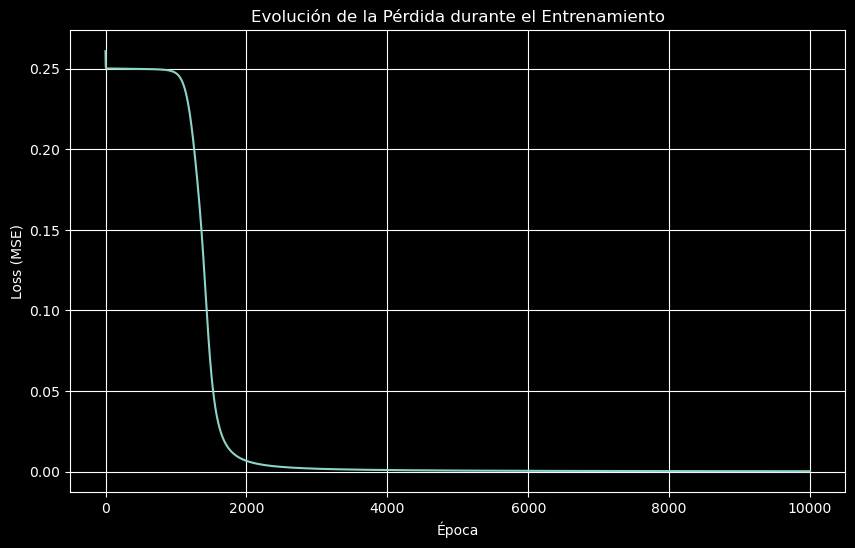

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

Por último, evaluamos el rendimiento de nuestro modelo en el conjunto de entrenamiento.

> Tener en cuenta que definimos un umbral de 0.5 para clasificar las salidas. Si la salida es mayor que 0.5, la clasificamos como 1, de lo contrario, como 0.

In [18]:
with torch.no_grad():
    final_outputs = net(X) # hacemos la inferencia (todos al mismo tiempo)
    for i in range(len(X)): # separamos caso a caso para imprimir uno por linea
        predicted = final_outputs[i] # la salida del caso
        expected = y[i] # lo que se espera del caso
        prediction_binary = torch.where(predicted > 0.5, 1., 0.) # la clasificación binaria
        print(f"Entrada: {X[i]}, Esperado: {expected}, Predicho: {predicted} → {prediction_binary}") # comparamos

Entrada: tensor([0., 0.]), Esperado: tensor([0.]), Predicho: tensor([0.0097]) → tensor([0.])
Entrada: tensor([0., 1.]), Esperado: tensor([1.]), Predicho: tensor([0.9852]) → tensor([1.])
Entrada: tensor([1., 0.]), Esperado: tensor([1.]), Predicho: tensor([0.9845]) → tensor([1.])
Entrada: tensor([1., 1.]), Esperado: tensor([0.]), Predicho: tensor([0.0185]) → tensor([0.])
